In [2]:
import pandas
import numpy as np
from utils import *
import mne
import matplotlib.pyplot as plt
from os import walk
from sklearn.decomposition import FastICA
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import cross_val_score
from itertools import combinations
from sklearn.preprocessing import normalize
from tqdm.notebook import tqdm
import pickle

from multiprocessing import Pool
plt.style.use('seaborn-whitegrid')

In [3]:
def load_data():
    path, folders, filenames = next(walk('./data'))

    filenames.remove('11-audio.csv')
    filenames.remove('11-image.csv')

    filenames.remove('36-audio.csv')
    filenames.remove('36-image.csv')

    path = './data'
    columns = {'Unnamed: 1':'Fp1',
            'Unnamed: 2':'Fp2',
            'Unnamed: 3':'F3',
            'Unnamed: 4':'F4',
            'Unnamed: 5':'F7',
            'Unnamed: 6':'F8',
            'Unnamed: 7':'P7',
            'Unnamed: 8':'P8'}

    EEG_audio, EEG_image = dict(), dict()
    from itertools import product
    categories = [1,2,3,4,5]
    blocks = [1,2]
    with tqdm(filenames) as t:
        for filename in t:
            t.set_description(f"{filename}")
            participant_id, stimuli = filename.split('-')
            stimuli = stimuli.rstrip('.csv')
            data = pandas.read_csv(f'{path}/{filename}', dtype={'Marker': str}).rename(columns=columns).drop(columns='timestamps')
            # Aviod warning on stim has negative value
            marker = np.array(data['Marker'])
            marker[marker == '-1'] = '1'
            data['Marker'] = marker

            if(stimuli == 'audio'):
                EEG_audio[int(participant_id)] = data
            elif(stimuli == 'image'):
                EEG_image[int(participant_id)] = data
            else:
                raise ValueError(f"Stimuli:{stimuli} is unexpected.")
    return EEG_audio, EEG_image


In [4]:
# clear_cache()
try:
    # Load from cache
    EEG_audio = load('EEG_audio')
    EEG_image = load('EEG_image')
    print('Load data from cache')
    if( set(EEG_audio.keys()) != set(EEG_image.keys()) ):
        extra = None
        if(len(EEG_audio.keys()) > len(EEG_image.keys())):
            extra = set(EEG_audio.keys()).difference( set(EEG_image.keys()) )
        else:
            extra = set(EEG_image.keys()).difference( set(EEG_audio.keys()) )
        raise ValueError(f"In equal keys. audio has {len(EEG_audio.keys())} and image has {len(EEG_image.keys())}. The extra key is {extra}")

except FileNotFoundError as e:
    EEG_audio, EEG_image = load_data()
    # Save to cache
    save(EEG_audio, 'EEG_audio')
    save(EEG_image, 'EEG_image')

Load data from cache


In [12]:
# filter_list = [[0,4],[4,8],[8,13],[13,30],[30,125]]
t_start, t_stop = (2.5, 3.5)
raw = dataframe_to_raw(EEG_image[33], sfreq=250)
# # Preprocess
raw.notch_filter([50,100],filter_length='auto', phase='zero', verbose=False) # Line power
raw.filter(1., None, verbose=False) # Slow drift
# ica = mne.preprocessing.ICA(n_components=8, max_iter='auto')
# ica.fit(raw, verbose=False)
# raw = ica.apply(raw, verbose=False)

events = mne.find_events(raw, stim_channel='Marker', initial_event=True, verbose=False, uint_cast=False)
events = np.delete(events,np.argwhere(events[:,2] == 1), axis=0) # break
# # Check data
# if(events.shape[0] != 50):
#     raise ValueError(f"Event missing: {events[:,2]}. len(events.shape[0])={events.shape[0]}")
epochs = mne.Epochs(raw, events, tmin=t_start, tmax=t_stop, baseline=(t_start,t_stop), verbose=False)
# if(epochs.get_data().shape[0] != 50):
#     raise ValueError(f"There might be a bad data. epochs.get_data().shape = {epochs.get_data().shape}")

# # Extract features

# for evoked in epochs.iter_evoked():
#     power,freq = mne.time_frequency.psd_array_welch(evoked.data,sfreq=250,n_fft=128, verbose=False)
#     break
times = np.arange(t_start,t_stop,0.25)

111


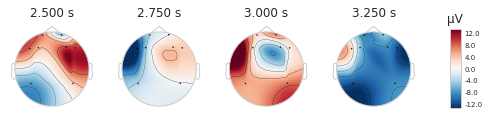

112


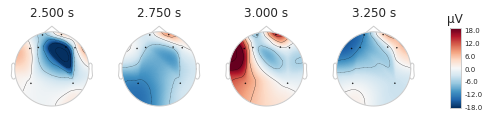

113


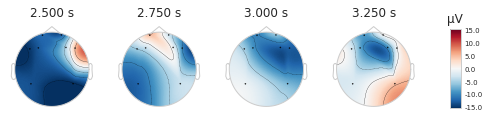

114


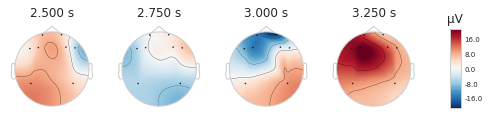

115


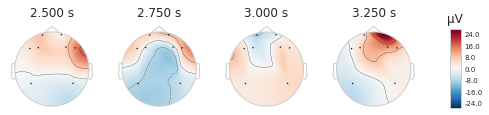

121


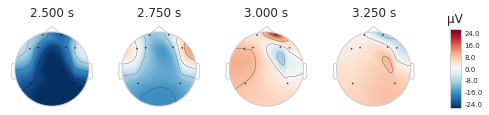

122


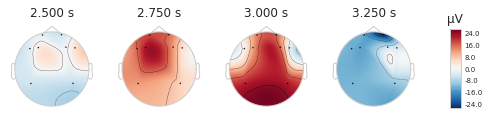

123


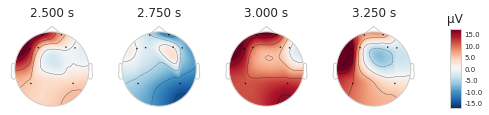

124


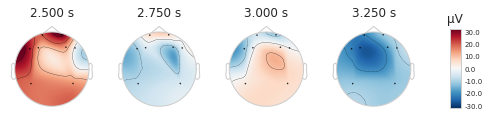

125


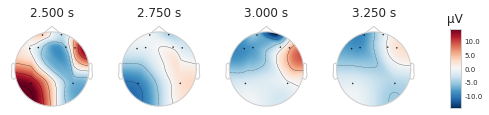

In [13]:
# # Extract features
print_list = [1]
for l in print_list:
    for evoked in epochs.iter_evoked():
        if(evoked.comment[0] != str(l)): continue
        print(evoked.comment)
        evoked.plot_topomap(times)
    # power,freq = mne.time_frequency.psd_array_welch(evoked.data,sfreq=250,n_fft=128, verbose=False)
    # break